In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow.keras import layers
import os
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import scipy

In [2]:
print(tf.__version__)
print(tf.compat.v1.config.experimental.set_visible_devices)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) 

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

1.15.0
<function set_visible_devices at 0x7f57976bbc20>
Num GPUs Available:  1


2022-06-23 14:10:51.851328: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-23 14:10:52.130264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 14:10:52.134345: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-06-23 14:10:52.137922: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-23 14:10:52.191812: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-23 14:10:52.207588: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0


Default GPU Device: /device:GPU:0


2022-06-23 14:10:52.571964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 14:10:52.573649: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a2ba72aa70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-23 14:10:52.573678: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): TITAN Xp, Compute Capability 6.1
2022-06-23 14:10:52.573853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 14:10:52.574584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-06-23 14:10:52.57463

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import glob

In [4]:
train_dir = 'CINIC-10/train'
test_dir = 'CINIC-10/test'

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
trainGen = ImageDataGenerator(rescale = 1./255)
testGen = ImageDataGenerator(rescale = 1./255)

In [6]:
train = trainGen.flow_from_directory(train_dir,
                                        class_mode='categorical',
                                        target_size=(224,224),
                                        batch_size=32,
                                         classes = labels
                                    )

test = testGen.flow_from_directory(test_dir,
                                  class_mode='categorical',
                                  target_size=(224,224),
                                  batch_size=32,
                                   classes = labels
                                  )

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


# MobileNet V2

In [7]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Adam Optimizer (MobileNet)

In [14]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
2813/2813 [==============================] - 137s 49ms/step - loss: 1.9425 - acc: 0.5365 - val_loss: 1.8918 - val_acc: 0.5850
Epoch 2/10
2813/2813 [==============================] - 138s 49ms/step - loss: 1.8747 - acc: 0.5987 - val_loss: 1.8716 - val_acc: 0.6014
Epoch 3/10
2813/2813 [==============================] - 137s 49ms/step - loss: 1.8556 - acc: 0.6157 - val_loss: 1.8591 - val_acc: 0.6106
Epoch 4/10
2813/2813 [==============================] - 132s 47ms/step - loss: 1.8441 - acc: 0.6258 - val_loss: 1.8523 - val_acc: 0.6152
Epoch 5/10
2813/2813 [==============================] - 138s 49ms/step - loss: 1.8347 - acc: 0.6360 - val_loss: 1.8511 - val_acc: 0.6142
Epoch 6/10
2813/2813 [==============================] - 135s 48ms/step - loss: 1.8283 - acc: 0.6411 - val_loss: 1.8471 - val_acc: 0.6188
Epoch 7/10
2813/2813 [==============================] - 134s 47ms/step - loss: 1.8233 - acc: 0.6460 - val_loss: 1.8414 - val_acc: 0.6248
Epoch 8/10
2813/2813 [===================

In [16]:
model.evaluate(test)

2813/2813 [==============================] - 113s 40ms/step - loss: 1.8398 - acc: 0.6242


[1.8397902363015375, 0.6241889]

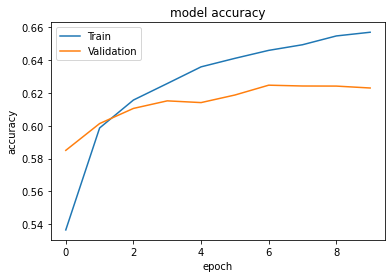

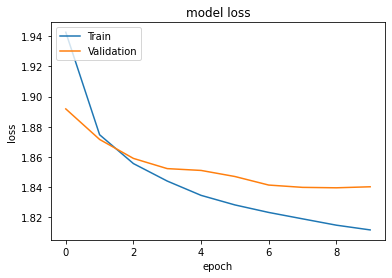

In [17]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_MN_Adam"
model.save(export_path)
# model.save(export_path, save_format = 'h5')

print (export_path)

savedModels/cinic_MN_Adam


In [19]:
# Get the saved model to perform further actions maybe.
export_path = "savedModels/cinic_MN_Adam"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2813/2813 [==============================] - 111s 40ms/step - loss: 1.8398 - acc: 0.6242


[1.8397890363687135, 0.6241889]

# Example on an image from the internet

In [35]:
import urllib.request
from tensorflow.keras.preprocessing import image


# url = "https://image.freepik.com/free-photo/front-view-nice-street-city_23-2148798644.jpg"
# url = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBISFRISERIYGBEYEhISEhgSEREYEhESGBgZGRgYGBgcIS4lHB4rIRgZJjgmKy8xNTU1GiQ7QDszPy40NTEBDAwMEA8QHhISHjYrJSs0NDQ0MT80NDQ0NDQ0NDQxNDQ0NDE0NDQ0NDQ0NDQ0NDQ0NDY2NDQ0NDQ0NDQ0MTQ0NP/AABEIAMIBAwMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAACAwABBAUGB//EADsQAAIBAgUCAwUGBQMFAQAAAAECAAMRBBIhMUEFUSJhcQYTMoGRI0KhsdHwFBVSYsFyguEzNKLC8ST/xAAaAQADAQEBAQAAAAAAAAAAAAAAAQIDBAYF/8QAKREAAgIBBAIBAgcBAAAAAAAAAAECESEDBBIxQVEyE6EVImFxkbHBFP/aAAwDAQACEQMRAD8A6FpREcFglZmairS7Q8svLEMACWBCCy7QAAiCRHFYJWAhVoQEvLCCxiZQEILCAlgRiKAhASwIVoA2DaCwjbQSICFgRiygIQEGJl2gkQ7SiJDJBtBYRloDRAKaJeOaJeAIQ8Q8e8S8CkJaJaOaJeMpAGSWJDAsGXJJACSSSQEelAlEQpLShg2ktCtJaAA2l2hCWBBADlkKw7SGOhCysq0MiUBARQEICQCEBARYEsCWBCUQEVaUVjLSFYAJyywIZEloMTBtJaXIZDECYtoyLeAqEPFNGuYhjEMU5iXMa5iWMCkKaKaNYxTRlIqCYUGBRJdpUKAFWklyQEekEKCIQlDJJJJAChClS4AWJLSxLjEDaVlh2l2gIALDAlgQlEBFBYQWEoi62Jp0/jax7cwAZaXlnITrwLZVphtSLm5A/wATv4aq7L4lVWygg3Nyy/QnzPltIlqwgrk6HGEpfFWZCsq0e2OIIBAtyGAPz1jM1N9lIa9vDqp+XHy85y/iO2bpP7G72eqlbRiIlGaTh3OyMfMAkfURL02G6keoM66bVnI8OhRi3jSItpLAz1Ih5oqTO8AEMZnYxzxDRFIBjAMIwSYy0DKkJkjGSXKhQAq0kuSAHpBCEBTDlASXKEsQAksSGUDAA7SxIISxiKtLAhAS4CKyywsICCzfdHxW+kBMw9V6kKIsutQjT+3zM8oRWxDG2Yrfxa2BP9xvPU4jpyXLOSzG1+CL9v32hth1y5QmUW4JHFydJotJ/KXSM3O8RPNYbCVVe4sHVKhS5OXOB4fu2Iv3nlaftJimdUAqGr7wXzVGOmmYFLZRybi1p9Fw1JbNmIHcg3ubcFr67fWHhqVFGLBFLa97g8bj9J8jV30FOSlFP1Z9bT2cnGLTa/YpqjsEXQuQBwCSdv3zPPdV6tiad6aKS5FvsywYcb2DDa209HVrMzZtL37bSqWEBcXtYtd9LF3IDEn98T5mjOEJcnFP0fQ1YScKujyuF6N1PFoorVjRo6lQ7O7tfW4W+3+o+gtPT9G6FSwgPu2d3YWd6jksRe9gNlHoOBe87TnUxTT0vOUllnm2knhAGKaNaKaQxCKkzvNFSZ6kBoztM7R7RLxFJCDAJhtAMaKRUuVJGMuXKkgBd5JUkAPSKYQMUphgxjDBhCLEMGMQRlSSRgMWGBFoYYMBBgQhBvObjepZR4e/O79gv6wsRqxuKyL4SM17d8o50HM5+HxNSxLC22ynMPXXXTiIfHWGpuTrZdFHoPWCheofhI7W+6O5biOMqZMk2jp0q7EAFjbXfS/kb+sz1qbo2ZCt9Vsfhsdblb6zRhcHVYWVfDuWLhQo5Ntzzt34kenTfwlipU8m+w3AvL3OovoN+8D2sL1kq6yZfGRstwdTa1/kP35yjcbG53JtYbceUih1NrgjYa/4mlKYb4uxH0/YnjZyznJ6xVFGWkzEjbg/L92nTwWHzXblbsdd7G0zphr2A76es7WEw9lsT6W7Q05rnF+Ezn3MlwaXkykxbQ3FiQeNItjPVppq0eZeGAxiXMYxiXMQhbmIcxjmJcxFCHiWjXMS8CkJaAYbQTBFIqXaVLlDIJdpAJdoCKtJCtLgI7awwYoGGpjGNEIRYMMGMApJJcYiwY6mpY2H/A9ZmdwoLMbKNSe04ON6zUe4pKFp7B3JCE+QGrnTbb1kykkUo2e0o+4HgdszsLLl2zcAnYTy+IyLVdXuSDa4INzvYHXuO3znmFxGaqlSrVZ8hDLmIC5uMq7DbbTabK+OqVq6gOq65j7w0wzX3LZ9l15vMLlKVF1FI7VX3dvs0Je+pyliPXtDwNLFuwL0nFNblmdMlIrx4nteNfr1PCqFQF6g00LikjdlZwNv7VnD6h1PE4ls1Zxkv4UJIpj5bsfMzrhpJVbOac/CR7B+qBQUUgrYX92ECj/cALzz+NqkNmzZQTewFrDzvMuHe24vYcXVbet729IrG1c+WxGmtlH+eZrvuC27T9BsXL/oi17OjTxAMYtW2l/xnJwz230O9jvbuZvIsAb3Op/L9/OeNlBJnr+d9HUo4q22/n+/3adWlXBAsdtT6bfWeUp4gLuZqTH237i3mOJlLTfhGU9NSOzVe5J/emkUxg4drop9fzMtp6fbprRin6R5rXr6rr2xbmJYxrzOxmpkgXMzuY1zEOYhoU5inMNjFNApAGCYRgxlIgkEkICMZYEICRYYgSyrSQpIAdIGGpigYamMY0QwYsQljAMGMQE6CLE817W9fWkpoo9nI+0Knxf6fKFiNXtD1yhT+zVgzD4je6Zu2UfFPI4jqxcMwJIOhZtEHkW/9V2/qWcrA4JsQxOiUl1d32A8hyfwnsOlvTxIp0EQHDoS6g7uV0zN38hMpRSyyk34OZ0zpFTFEHOyrY5nAsSNLhTx8rk8tOr/ACmnhARTzGoQblTYeQzcnkk8+QE71fFJTVQqhVt4r6H0tMAqmu1r2HYWt6C0iGpcqCSdHHpUbtme2bYaA5BwFB2mh6yDW5uNNSdfM/pNGOwRp/EQB2uCx+Uz0lp6lwbAcjWdMVJMwk0zLVLtchiFPAB18zHUCFFiTfteDiay2OU2Xi/4f/BOZVxR2A8r+Ux3SyvODo2r8XR0nxYBJHO95aYtiQLm19ztac13NvXUeUA5rgC+bgCfM+kj7kdTFneruL+HU2A3jKNTVCe9/wBBOl0rouSmK2LbKuVnKqPF2APnMHRqPva1/uIc7dr38Iie2kmk/Jmt7FqTXj+D1KLlVV7KAfXmAxhuYljPrUkqR8Fu3bBcxDGMYxTGACniWjXMQ5iGhTRbQ2i2gikDBhSRlFAQwJQhqIAWBCAkAlgRkktLlyQEawYwGKEMGMocDLBiwfp5zLi+s0aXOd/6V2hYDOqvXWkxw63ciwPC+c+W4zCVQ9n8bsbsAbknzM9jiuqYjEnKt1TYKn+TNXS+gFTnqGx/GZ8pOWOhuqPNUuj4mogV2CIBoq6TvezNL+DciopKkDIeCO09CuFHf6iKqYJjvYjjylNYwS7byFjhTqDPsv8ASTqD6a6TAtejSuA2vNrm86FXpqFcwNmt4r5bX8gZwMXhaZOup5vsPSYuLiF2PepTqWe3hHc7+o59PzmR1BNhovF+fOVh8A17s/g4u346RmIqKugYHztqeBbWdUJ4MpRoRXC720HESSADoMxFvSG68aam9hxLUa2G2vG57wn+ZBF8WYDh2cqFuTpwdJ6jovT6dO1RwC/9x0B/zMmGFtSJuw9Nqhyr3ufLzJmENFJ28m2puZyXFYE9Vxteu/u1vkJCqo2PnO303BCggQfFu57t+kbhsItMd25P6RzSlp1Jybt/0TzfFRSpAsYtjLYxbSmSA0W0NjFsYgEvEvGuYloikLaLMNoEENFWktCAktGUUBGgQVENRAkgEMCQCGogIq0kZaSMRA0HE4gU1LH5CUDCYA7i8PBaPM4vFYqsdFK0+ANzHdO6DUbxVPCvbk+pno1A7CMBi4+2NsHDYVKYAVR68zReADLBlJUIYDCBirw1gBKtIOCNrzyuM6fikrgAZ6J2KgGw50PM9cpg4rDrUQo2xGh7HvDin2I4+O6fUAFuwJ1F5xKiEG5U/IXne6K5Uvhq3xr/ANM2FmXt/mPxHSHY3Rx87wcV3EmmsM80aJYzRQoW415mirRFCqi4gMKTaZ1tkDcA9hPUUsNTUDKotuDvfzvzJVsHBpJvycjA9KZ7M/hXt94/pO3TpKgyqLD8/WWJDNEqFRRgtLMExALaLaMaJaSwFsYlmjHiWiBAsYhoxjFNEUC0CExg2jGEsKUJYgOywIaiCsYsCWEBDUQRDWAiWkhWkjFZmUxgnpK/Qabkmm1vTacvGdIqU9vEvcbx0yzCphgwBpoYQiGMBhgxYhAxgGDDUxawwYANBhKYsGGpjAxdUwma1RNKiagjcgTbgcUKiBhvsw7GMWcitW/hahNvs3Gb0N9QPS9/mYuh1ao7GIoJUUo6gqdCDOTQz4RhTclsKTZGNyaR7H+2delUV1DKbqRcEciE6BgVYXBFiDzBq8rsIzrD6IDyNjqCNiJCZz0f+HIVz/8AnOim1zTPme06LpaxuCpF1YG6sO4MadomUayugDFkwyYtjEQUxiWhsYtzEAmpEMY5zM7mIEA5imaE5i0BLAAXJIAHck7QKKJkE7mL9nqru74dENO+iiqmZbCxuCdNQZyq2ArU2yPScNwMpN/QjQxWhKUX0wBII7CYV6hYINVUsR6biKQEkAbk2HrFyVtX0O0WIwSYii1NijizC1x6i8ERppq0K7DBjFiljUMYmMklXkjAV/OHpuVU3A0/ZnpOl9ZFRbN8XnaeMp4Ej7QtodZrwNRVPx2J2i5NG6jk9bVoUqh8QAPynOxfS8uqG47R+GNJFDVGueLGb6LU31Rh6GClfY5aVdHm3plTZhYyp6HF0RrmXS3aYE6bnuVMqvRk8dnPEgmipg6i8XHlEHTeIQQMapiBCFQqhewBtdbnUDe57XHHnKSsG6NWIU01DOLXFwLjMflOJ1quHRbU7gWqXcqLjYqNb63i61Sq1qgIdAMykXZW11DHfkfT0isRi1xKZVVRVAyjM1gR/aQDf/nmVRLl6FjqIo1GQ1MlNgrUcuqqxAOVgRqCfTeb6eKxgfN4Xp2uVKZSynlGE8zVwlRRUapZmD5XFwVAb4SOw0t309Jp6V1dnQUqp1W4ptu5GrAEE7Hb1I2vFWR8sHpKfUaeKpOEXxsrKEqAhcw/u285iwXUmw+HRqmZqKYg0XVQPs2dbqwPOq6g/wBQmWvicpBdxr2UKSDoOdDM1GgT7wMfs3Kls2Y51VgWsBqToNbcDzsNegjOsSWD16uHRaiG9NhdWFiD5abHygsZyOm4Vg7NRxKgMijKyOi32BYuuUmb8O9TQYirRZtbGiovodL2CjURKMn4CXHuLDYxbNNn8EWGZHRhsfEAVPmNvxiWwFUmwT/yQD63icZLwTZhqNM7mbWwb5lV7IGNruygDz31mmvg8HTH/dB6gPwZkRb/AD2ktSXgTkkN6V0Auq1ajhVNilgrhvJhfSdCh0LDlldahR1Y3sAUJ2BtsNZjdKhS2FFMMTdgapY621CqPynAHS8eLk4nDhS9wDUqkWG6gBAT87TkcdeU+UVj9cHNy1ZStYPYUaYw9NadN1LirmqtkGaspJ0Yb8jXynRwmPQDKWUKLi4Yk76gAbTyYxdChnWtUWq6hT973epsRfm1+fpGJ17paLd6VNW3sF8+AN9TGttrSfKTSfoqOlJ5bPS0+m0lqPWpNZnpsrKdmvs3kYrpXs3RpNncF3DErdrKvbTk+cw4H2kwlUWo5CuUbJYrqdCDtNrddphtSNtDc6es0W21li1X+F8ZIvq/Q0qVUqFVVdc1iS1RtLA8W0iG6ShxAbS2VSRtdtjp9I+v1EVL+C6gXBv4fwMxVMaSbIFzZfvM+t9e1zbsJOptddytNVVJX4Eoy8GbEdAGdyKiKpJ92oubHgMeBMtToeIUXFPOvemwcfQa/hNA6q6eNaaBtibM12AOo7zPh/aIKVucrCwXKXAbMdbqBbTv5zeGjqRWWn+haU0Y/csN1PzUyT0A9pD/AFj5lb/lJK4anr7h+b0fOKmKqVBpoBp6x+CwZqAM5sYGDqq1l45kxOMNNrILxS9HZH2x1atkOUsdNtYWG6oEIy1DmnGxGL1uy6nvMSV7ve1oKOBOecH0nD+1NRUs6BvOPw3tNTBuyWB7cTyNNwyCzbCBUqaeIzNtpm6jGSPd/wA2osbioAPOaU9xUBNxa1ydLAes+VfxNidbzt9HxVaotRF0QU2NRrXCKdB8ze02Ts5nGmdjA9dw74hgpApoAFNwweo1+PIbepnP651ioCDfVmNsqrcBbEAegub+s811JKNCoBnDFCD7unYFjcX19AfFqJ0ekdWwro7VKa3dmVc1/skFhZeL8k3F5SfgzaO7TcBVLpkYqCpe3u213Bvl3J034tAxnS6dQhlBUXTMrI1rtpcOPu827DymrD9PenTdkCvTfUB6qghrAFQHsvnqeflEvgcVUoMtNjxlQZSpANwtyCbWFrAga2lXglxpnG6phKtC6k3DEqCtjY2Gx2Iv3trM4wpypehTFyFLZwCq9vCTrYdonHYvqtGwqUWy3yN7wKyWvfwm5y+u3lOtjQ1SiEdi7IVYlVTwPwFJGxsbfjEwDp4Ok6kqlhqfFUcoALcnUcTPh6Zp6HIaViSz5xTJJNvhsdDc/wC3U63lYaobIqhxnuVBKZranxAfM6X0MLrWJbBFadQMRbO5IaxZtdgdspsGt6gawohZOo2GpDKgLfdKFCQqsygk63uOOSAN5zUoBLKWQnMNAdcp5BGn1+k5/UvaXDEqKVRiuXVSGVVNhcqctieO1u0xYfrKZ/Dq3cupCkDTQGzX7iNMtr0ewHUXUKb2W2jHW63NibHXQbi81J7SC6FaYZRZWuviIuPhtr2taeaPWvCVNRSC1gF0GYkg3vYqdz5xLdTVQTlAN7qEDWVrW5G36xuTEoo3e1fUEr5bI2miA5yO7XDWsdJ5Cv1BgcjHQEAs3xfIj6TqYjGGoPG1lBPhKvcn/X8X4zkYnF07FDT8N7g3OYHyMltj6E/zeqpze8ueDrfTa9v0hv1es13Vxcjxcm/JsdrzH7pH0Vrci4v8jM6oqnXXXtpcHiMDX/M6hvmuTtfe3ykTHsWDM5B0tmXc+VopgNxovIv+UGo6Di/nqSfrJHZ2aPVGANhrcEkEq34TantDUAW9mtfLd9bdib3+c8q9ccG1ttxf6ShXa2rjy3jQWe4pe2FgFRXQW8VnXKTbZRa/4zbgvadCfG2pFvETxxff6ifOvf66n6aRi1tLXA76nU/syuTCz6TS6uGayVFzmwN289ddB5RmIxVMFVyZzfJbMhAPpf5fSfNErEkDPoLaC1h6CN9866b7WOWxBHYjWHID346gw0yMLEiwy6WNuDJPC/xtUbF/lUP6yocgtnfwW5myjzJJMPJsujHid5jX73zkklozfZswE14r/EuSZy+R0afxZyKm89B0FiKOIsSNtj/aZJJRmuzw2L3qeo/Oaujb1Rx4PTcSpI49ES+R6JXPuG1O6jfjTSelwFRhSaxI8dPYn+oS5JpEzkbsxfDDOc2v3tfznJxlNVKFQAfc0/hAHbtJJB9hH4mbrGxPOU68/COZ5brmLquy56jtZBbM7G2nnJJKl2yInnK/6xC7ySSSjqhjZdT9fWb0qNY6n4zyfOSSSMy1KzX+I7n7xiatRtNT9TJJKEIq7/WCu49P1kkiY0ZxLkkjELMuSSAFGSSSADE4mgbH5ySRMBibCSSSQWf/2Q=="
url = "https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png"
urllib.request.urlretrieve(url, 'image.jpg')

# Load image and resize (doesn't keep aspect ratio)
img1 = image.load_img('image.jpg', target_size=(224, 224))
# Turn to array of shape (224, 224, 3)
img = image.img_to_array(img1)
# Expand array into (1, 224, 224, 3)
img = np.expand_dims(img, 0)

img = img /255

[[0.09804525 0.00000001 0.572698   0.3225534  0.00000002 0.00000645
  0.00000212 0.00060904 0.00605966 0.00002605]]
This image is a bird


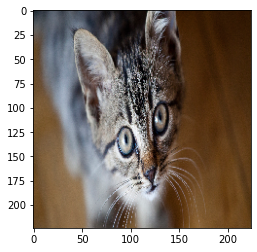

In [36]:
np.set_printoptions(suppress=True)
pred = reloaded.predict(img)
print (pred)

print ('This image is a', labels[np.argmax(pred)])
plt.imshow(img1)
plt.show()

# SGD Optimizer (MobileNet)

In [20]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
model.compile(
  optimizer="SGD",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
2813/2813 [==============================] - 139s 50ms/step - loss: 2.1342 - acc: 0.3449 - val_loss: 2.0804 - val_acc: 0.4058
Epoch 2/10
2813/2813 [==============================] - 136s 48ms/step - loss: 2.0592 - acc: 0.4216 - val_loss: 2.0486 - val_acc: 0.4310
Epoch 3/10
2813/2813 [==============================] - 133s 47ms/step - loss: 2.0382 - acc: 0.4394 - val_loss: 2.0338 - val_acc: 0.4433
Epoch 4/10
2813/2813 [==============================] - 135s 48ms/step - loss: 2.0267 - acc: 0.4492 - val_loss: 2.0246 - val_acc: 0.4510
Epoch 5/10
2813/2813 [==============================] - 134s 48ms/step - loss: 2.0189 - acc: 0.4566 - val_loss: 2.0183 - val_acc: 0.4566
Epoch 6/10
2813/2813 [==============================] - 139s 49ms/step - loss: 2.0132 - acc: 0.4607 - val_loss: 2.0131 - val_acc: 0.4645
Epoch 7/10
2813/2813 [==============================] - 136s 48ms/step - loss: 2.0089 - acc: 0.4637 - val_loss: 2.0092 - val_acc: 0.4672
Epoch 8/10
2813/2813 [===================

In [22]:
model.evaluate(test)

2813/2813 [==============================] - 109s 39ms/step - loss: 2.0029 - acc: 0.4694


[2.002924085129549, 0.46942222]

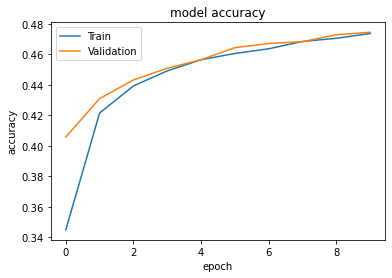

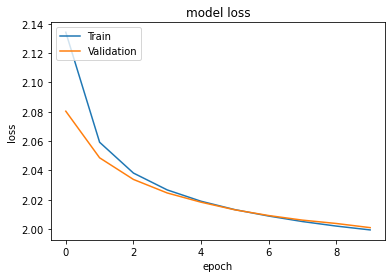

In [23]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_MN_Sgd"
model.save(export_path)
# model.save(export_path, save_format = 'h5')

print (export_path)

savedModels/cinic_MN_Sgd


In [25]:
# Get the saved model to perform further actions maybe.
export_path = "savedModels/cinic_MN_Sgd"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

2813/2813 [==============================] - 112s 40ms/step - loss: 2.0029 - acc: 0.4694


[2.002912270018438, 0.46942222]

# Newton Optimizer (MobileNet)

In [8]:
import newton_cg as es

In [9]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes, activation='softmax')
])

model.summary()

2022-06-23 14:17:43.337552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 14:17:43.338530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-06-23 14:17:43.338583: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-23 14:17:43.338608: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-23 14:17:43.338631: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-06-23 14:17:43.338653: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
newton_opt = es.EHNewtonOptimizer(0.001)

model.compile(
  optimizer=newton_opt,
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

2022-06-23 14:18:54.826807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 14:18:54.828352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-06-23 14:18:54.828444: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-23 14:18:54.828500: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-23 14:18:54.828538: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-06-23 14:18:54.828571: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.

Epoch 1/10
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.


2022-06-23 14:19:03.745642: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-23 14:19:04.585188: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


2813/2813 [==============================] - 325s 116ms/step - loss: 2.2435 - acc: 0.2190 - val_loss: 2.1882 - val_acc: 0.2855
Epoch 2/10
2813/2813 [==============================] - 176s 62ms/step - loss: 2.2541 - acc: 0.2119 - val_loss: 2.3586 - val_acc: 0.1007
Epoch 3/10
2813/2813 [==============================] - 177s 63ms/step - loss: 2.3311 - acc: 0.1241 - val_loss: 2.3183 - val_acc: 0.1398
Epoch 4/10
2813/2813 [==============================] - 178s 63ms/step - loss: 2.3190 - acc: 0.1357 - val_loss: 2.3624 - val_acc: 0.0979
Epoch 5/10
2813/2813 [==============================] - 142s 51ms/step - loss: 2.3623 - acc: 0.0980 - val_loss: 2.3628 - val_acc: 0.0977
Epoch 6/10
2813/2813 [==============================] - 137s 49ms/step - loss: 2.3622 - acc: 0.0982 - val_loss: 2.3628 - val_acc: 0.0977
Epoch 7/10
2813/2813 [==============================] - 133s 47ms/step - loss: 2.3622 - acc: 0.0982 - val_loss: 2.3628 - val_acc: 0.0978
Epoch 8/10
2813/2813 [=============================

In [11]:
model.evaluate(test)

2813/2813 [==============================] - 262s 93ms/step - loss: 2.3612 - acc: 0.0996


[2.3612489353665413, 0.09962222]

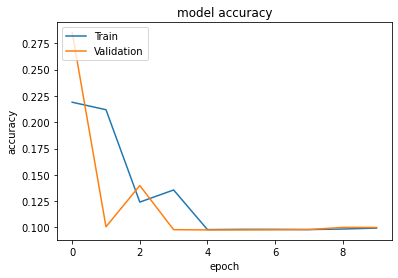

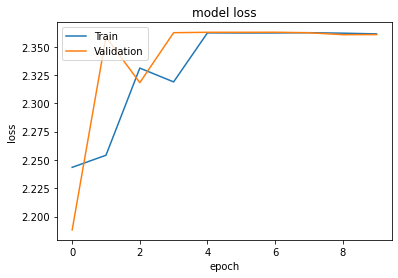

In [12]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_MN_newton"
model.save(export_path)

export_path

'savedModels/cinic_MN_newton'

In [ ]:
# Get the saved model to perform further actions maybe.
export_path = "savedModels/cinic_MN_newton"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer, 'MyOptimizer': newton_opt})

reloaded.evaluate(test)

# -----------------------------------------------------------------------

# Inception_v3

In [15]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

# Adam Optimizer (Inception)

In [8]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

2022-06-17 15:50:16.842083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 15:50:16.843061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-06-17 15:50:16.843116: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-17 15:50:16.843142: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-17 15:50:16.843165: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-06-17 15:50:16.843189: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [9]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

2022-06-17 15:52:14.255146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 15:52:14.256639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2022-06-17 15:52:14.256732: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-17 15:52:14.256778: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-17 15:52:14.256837: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-06-17 15:52:14.256876: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.

Epoch 1/10


2022-06-17 15:52:23.804940: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-17 15:52:24.524722: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


2813/2813 [==============================] - 326s 116ms/step - loss: 0.7992 - acc: 0.7310 - val_loss: 0.7354 - val_acc: 0.7535
Epoch 2/10
2813/2813 [==============================] - 165s 59ms/step - loss: 0.7176 - acc: 0.7568 - val_loss: 0.7175 - val_acc: 0.7617
Epoch 3/10
2813/2813 [==============================] - 168s 60ms/step - loss: 0.6865 - acc: 0.7665 - val_loss: 0.7873 - val_acc: 0.7416
Epoch 4/10
2813/2813 [==============================] - 166s 59ms/step - loss: 0.6723 - acc: 0.7721 - val_loss: 0.8138 - val_acc: 0.7373
Epoch 5/10
2813/2813 [==============================] - 167s 59ms/step - loss: 0.6628 - acc: 0.7744 - val_loss: 0.8254 - val_acc: 0.7364
Epoch 6/10
2813/2813 [==============================] - 167s 59ms/step - loss: 0.6537 - acc: 0.7771 - val_loss: 0.7846 - val_acc: 0.7441
Epoch 7/10
2813/2813 [==============================] - 166s 59ms/step - loss: 0.6478 - acc: 0.7780 - val_loss: 0.7604 - val_acc: 0.7465
Epoch 8/10
2813/2813 [=============================

In [10]:
model.evaluate(test)

2813/2813 [==============================] - 231s 82ms/step - loss: 0.7289 - acc: 0.7648


[0.7288962081710385, 0.76475555]

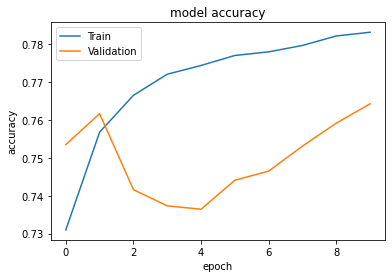

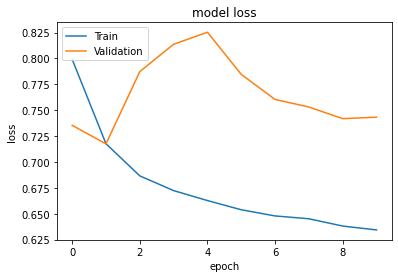

In [11]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_inception_adam"
model.save(export_path)
# model.save(export_path, save_format = 'h5')

print (export_path)

savedModels/cinic_inception_adam


In [13]:
# Get the saved model to perform further actions maybe.
export_path = "savedModels/cinic_inception_adam"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2813/2813 [==============================] - 138s 49ms/step - loss: 0.7289 - acc: 0.7648


[0.7288962081710385, 0.76475555]

# SGD Optimizer (Inception)

In [14]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [15]:
model.compile(
  optimizer="SGD",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
2813/2813 [==============================] - 175s 62ms/step - loss: 0.8084 - acc: 0.7274 - val_loss: 0.7180 - val_acc: 0.7526
Epoch 2/10
2813/2813 [==============================] - 173s 61ms/step - loss: 0.6980 - acc: 0.7598 - val_loss: 0.7031 - val_acc: 0.7580
Epoch 3/10
2813/2813 [==============================] - 172s 61ms/step - loss: 0.6695 - acc: 0.7691 - val_loss: 0.6942 - val_acc: 0.7577
Epoch 4/10
2813/2813 [==============================] - 167s 59ms/step - loss: 0.6511 - acc: 0.7747 - val_loss: 0.6965 - val_acc: 0.7590
Epoch 5/10
2813/2813 [==============================] - 172s 61ms/step - loss: 0.6396 - acc: 0.7790 - val_loss: 0.6682 - val_acc: 0.7687
Epoch 6/10
2813/2813 [==============================] - 172s 61ms/step - loss: 0.6284 - acc: 0.7822 - val_loss: 0.6719 - val_acc: 0.7690
Epoch 7/10
2813/2813 [==============================] - 169s 60ms/step - loss: 0.6208 - acc: 0.7850 - val_loss: 0.6606 - val_acc: 0.7725
Epoch 8/10
2813/2813 [===================

In [16]:
model.evaluate(test)

2813/2813 [==============================] - 134s 48ms/step - loss: 0.6726 - acc: 0.7666


[0.6726169128976087, 0.7665667]

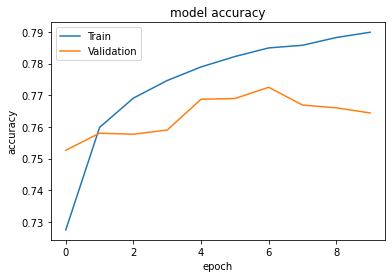

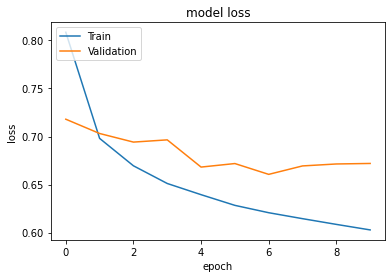

In [17]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_inception_Sgd"
model.save(export_path)
# model.save(export_path, save_format = 'h5')

print (export_path)

savedModels/cinic_inception_Sgd


In [19]:
# Get the saved model to perform further actions maybe.
export_path = "savedModels/cinic_inception_Sgd"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

2813/2813 [==============================] - 146s 52ms/step - loss: 0.6726 - acc: 0.7666


[0.6726199469022212, 0.7665667]

# Newton Optimizer (Inception)

In [16]:
import newton_cg as es

In [17]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [18]:
newton_opt = es.EHNewtonOptimizer(0.001)

model.compile(
  optimizer=newton_opt,
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
2813/2813 [==============================] - 255s 91ms/step - loss: 2.2215 - acc: 0.2426 - val_loss: 2.1447 - val_acc: 0.3421
Epoch 2/10
2813/2813 [==============================] - 245s 87ms/step - loss: 2.2373 - acc: 0.2141 - val_loss: 2.2651 - val_acc: 0.1789
Epoch 3/10
2813/2813 [==============================] - 249s 89ms/step - loss: 2.3516 - acc: 0.1056 - val_loss: 2.3645 - val_acc: 0.0944
Epoch 4/10
2813/2813 [==============================] - 242s 86ms/step - loss: 2.3588 - acc: 0.0999 - val_loss: 2.3618 - val_acc: 0.0962
Epoch 5/10
2813/2813 [==============================] - 269s 96ms/step - loss: 2.3573 - acc: 0.1010 - val_loss: 2.3638 - val_acc: 0.0935
Epoch 6/10
2813/2813 [==============================] - 271s 96ms/step - loss: 2.3560 - acc: 0.1022 - val_loss: 2.3606 - val_acc: 0.0976
Epoch 7/10
2813/2813 [

In [19]:
model.evaluate(test)

2813/2813 [==============================] - 143s 51ms/step - loss: 2.3544 - acc: 0.1041


[2.3543862687113273, 0.10407778]

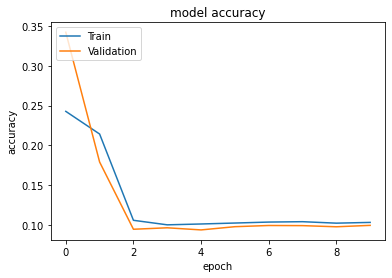

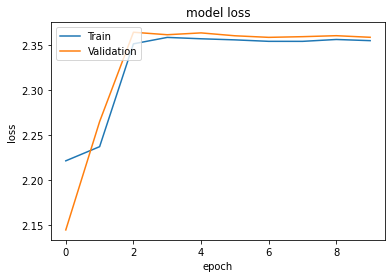

In [20]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_inception_newton"
model.save(export_path)

export_path

'savedModels/cinic_inception_newton'

In [ ]:
export_path = "savedModels/cinic_inception_newton"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

# --------------------------------------------------------------------

# ResNet Model

In [22]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

# Adam Optimizer (ResNet)

In [21]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [22]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
2813/2813 [==============================] - 195s 69ms/step - loss: 0.7395 - acc: 0.7453 - val_loss: 0.6962 - val_acc: 0.7575
Epoch 2/10
2813/2813 [==============================] - 184s 65ms/step - loss: 0.6437 - acc: 0.7765 - val_loss: 0.6883 - val_acc: 0.7610
Epoch 3/10
2813/2813 [==============================] - 176s 62ms/step - loss: 0.6201 - acc: 0.7836 - val_loss: 0.6775 - val_acc: 0.7708
Epoch 4/10
2813/2813 [==============================] - 179s 64ms/step - loss: 0.6076 - acc: 0.7885 - val_loss: 0.6706 - val_acc: 0.7740
Epoch 5/10
2813/2813 [==============================] - 180s 64ms/step - loss: 0.6013 - acc: 0.7921 - val_loss: 0.6961 - val_acc: 0.7670
Epoch 6/10
2813/2813 [==============================] - 179s 64ms/step - loss: 0.5973 - acc: 0.7918 - val_loss: 0.7179 - val_acc: 0.7644
Epoch 7/10
2813/2813 [==============================] - 179s 63ms/step - loss: 0.5891 - acc: 0.7953 - val_loss: 0.7439 - val_acc: 0.7568
Epoch 8/10
2813/2813 [===================

In [23]:
model.evaluate(test)

2813/2813 [==============================] - 146s 52ms/step - loss: 0.7729 - acc: 0.7557


[0.7728555909613888, 0.7557]

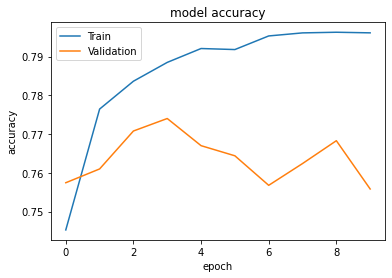

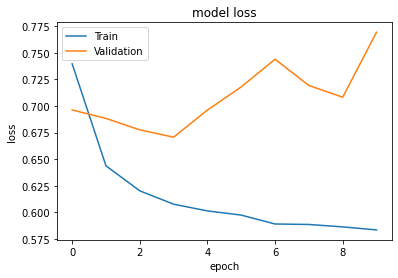

In [24]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_resnet_adam"
model.save(export_path)
# model.save(export_path, save_format = 'h5')

print (export_path)

savedModels/cinic_resnet_adam


In [26]:
# Get the saved model to perform further actions maybe.
export_path = "savedModels/cinic_resnet_adam"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

2813/2813 [==============================] - 153s 54ms/step - loss: 0.7729 - acc: 0.7557


[0.7728671279166078, 0.7557]

# SGD Optimizer (ResNet)

In [27]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [28]:
model.compile(
  optimizer="SGD",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
2813/2813 [==============================] - 192s 68ms/step - loss: 0.7466 - acc: 0.7406 - val_loss: 0.6701 - val_acc: 0.7639
Epoch 2/10
2813/2813 [==============================] - 188s 67ms/step - loss: 0.6428 - acc: 0.7745 - val_loss: 0.6508 - val_acc: 0.7750
Epoch 3/10
2813/2813 [==============================] - 188s 67ms/step - loss: 0.6163 - acc: 0.7824 - val_loss: 0.6401 - val_acc: 0.7739
Epoch 4/10
2813/2813 [==============================] - 188s 67ms/step - loss: 0.6001 - acc: 0.7888 - val_loss: 0.6515 - val_acc: 0.7765
Epoch 5/10
2813/2813 [==============================] - 188s 67ms/step - loss: 0.5874 - acc: 0.7912 - val_loss: 0.6427 - val_acc: 0.7766
Epoch 6/10
2813/2813 [==============================] - 188s 67ms/step - loss: 0.5801 - acc: 0.7942 - val_loss: 0.6392 - val_acc: 0.7773
Epoch 7/10
2813/2813 [==============================] - 189s 67ms/step - loss: 0.5728 - acc: 0.7958 - val_loss: 0.6322 - val_acc: 0.7779
Epoch 8/10
2813/2813 [===================

In [29]:
model.evaluate(test)

2813/2813 [==============================] - 155s 55ms/step - loss: 0.6459 - acc: 0.7769


[0.6459117625802596, 0.7768667]

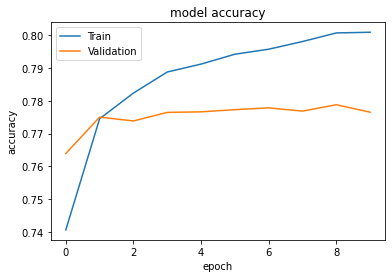

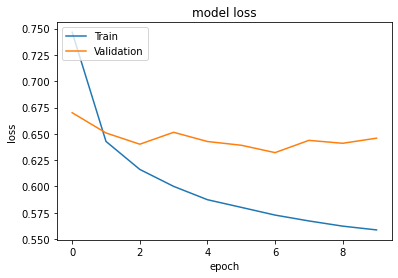

In [30]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [31]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_resnet_Sgd"
model.save(export_path)
# model.save(export_path, save_format = 'h5')

print (export_path)

savedModels/cinic_resnet_Sgd


In [32]:
# Get the saved model to perform further actions maybe.
export_path = "savedModels/cinic_resnet_Sgd"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

2813/2813 [==============================] - 155s 55ms/step - loss: 0.6459 - acc: 0.7769


[0.6459117625802596, 0.7768667]

# Newton Optimizer (ResNet)

In [23]:
import newton_cg as es

In [24]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [25]:
newton_opt = es.EHNewtonOptimizer(0.001)

model.compile(
  optimizer=newton_opt,
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
2813/2813 [==============================] - 260s 92ms/step - loss: 1.4111 - acc: 0.5208 - val_loss: 1.0142 - val_acc: 0.6579
Epoch 2/10
2813/2813 [==============================] - 233s 83ms/step - loss: 0.9161 - acc: 0.6824 - val_loss: 0.8527 - val_acc: 0.7004
Epoch 3/10
2813/2813 [==============================] - 223s 79ms/step - loss: 0.8190 - acc: 0.7092 - val_loss: 0.7968 - val_acc: 0.7186
Epoch 4/10
2813/2813 [==============================] - 228s 81ms/step - loss: 0.7789 - acc: 0.7205 - val_loss: 0.7693 - val_acc: 0.7268
Epoch 5/10
2813/2813 [==============================] - 232s 82ms/step - loss: 0.7547 - acc: 0.7274 - val_loss: 0.7519 - val_acc: 0.7337
Epoch 6/10
2813/2813 [==============================] - 229s 81ms/step - loss: 0.7385 - acc: 0.7326 - val_loss: 0.7383 - val_acc: 0.7387
Epoch 7/10
2813/2813 [

In [26]:
model.evaluate(test)

2813/2813 [==============================] - 147s 52ms/step - loss: 0.7191 - acc: 0.7441


[0.7190577255643393, 0.7440889]

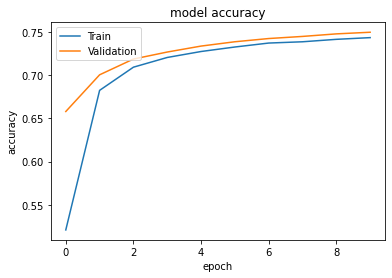

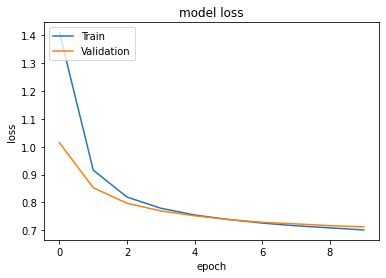

In [27]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_Resnet_newton"
model.save(export_path)

export_path

'savedModels/cinic_Resnet_newton'

In [ ]:
export_path = "savedModels/cinic_Resnet_newton"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

# ------------------------------------------------------------------

# NasNet Model

In [29]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/5"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

# Adam Optimizer (NasNet)

In [34]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1056)              4269716   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                10570     
Total params: 4,280,286
Trainable params: 10,570
Non-trainable params: 4,269,716
_________________________________________________________________


In [35]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
2813/2813 [==============================] - 195s 69ms/step - loss: 0.8250 - acc: 0.7138 - val_loss: 0.7600 - val_acc: 0.7362
Epoch 2/10
2813/2813 [==============================] - 179s 64ms/step - loss: 0.7419 - acc: 0.7381 - val_loss: 0.7521 - val_acc: 0.7375
Epoch 3/10
2813/2813 [==============================] - 179s 63ms/step - loss: 0.7235 - acc: 0.7452 - val_loss: 0.7547 - val_acc: 0.7363
Epoch 4/10
2813/2813 [==============================] - 179s 63ms/step - loss: 0.7161 - acc: 0.7477 - val_loss: 0.7419 - val_acc: 0.7403
Epoch 5/10
2813/2813 [==============================] - 179s 64ms/step - loss: 0.7081 - acc: 0.7502 - val_loss: 0.7553 - val_acc: 0.7394
Epoch 6/10
2813/2813 [==============================] - 179s 64ms/step - loss: 0.7052 - acc: 0.7503 - val_loss: 0.7610 - val_acc: 0.7351
Epoch 7/10
2813/2813 [==============================] - 178s 63ms/step - loss: 0.7014 - acc: 0.7535 - val_loss: 0.7545 - val_acc: 0.7375
Epoch 8/10
2813/2813 [===================

In [36]:
model.evaluate(test)

2813/2813 [==============================] - 143s 51ms/step - loss: 0.7513 - acc: 0.7398


[0.7513069121297509, 0.73976666]

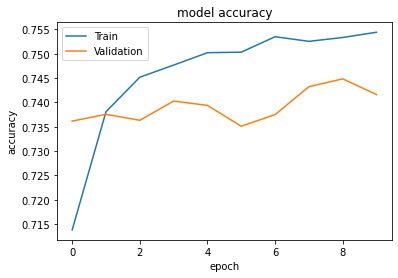

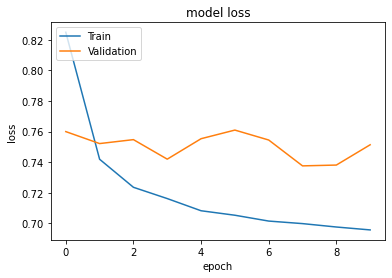

In [37]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_Nasnet_adam"
model.save(export_path)

export_path

'savedModels/cinic_Nasnet_adam'

In [39]:
export_path = "savedModels/cinic_Nasnet_adam"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

2813/2813 [==============================] - 158s 56ms/step - loss: 0.7513 - acc: 0.7398


[0.7513002334775087, 0.73976666]

# SGD Optimizer (NasNet)

In [40]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1056)              4269716   
_________________________________________________________________
dense_5 (Dense)              (None, 10)                10570     
Total params: 4,280,286
Trainable params: 10,570
Non-trainable params: 4,269,716
_________________________________________________________________


In [41]:
model.compile(
  optimizer="SGD",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
2813/2813 [==============================] - 204s 72ms/step - loss: 0.9204 - acc: 0.6863 - val_loss: 0.8371 - val_acc: 0.7133
Epoch 2/10
2813/2813 [==============================] - 183s 65ms/step - loss: 0.7876 - acc: 0.7249 - val_loss: 0.7929 - val_acc: 0.7248
Epoch 3/10
2813/2813 [==============================] - 183s 65ms/step - loss: 0.7604 - acc: 0.7336 - val_loss: 0.7820 - val_acc: 0.7286
Epoch 4/10
2813/2813 [==============================] - 184s 65ms/step - loss: 0.7450 - acc: 0.7381 - val_loss: 0.7699 - val_acc: 0.7300
Epoch 5/10
2813/2813 [==============================] - 183s 65ms/step - loss: 0.7335 - acc: 0.7414 - val_loss: 0.7660 - val_acc: 0.7338
Epoch 6/10
2813/2813 [==============================] - 182s 65ms/step - loss: 0.7249 - acc: 0.7436 - val_loss: 0.7612 - val_acc: 0.7343
Epoch 7/10
2813/2813 [==============================] - 183s 65ms/step - loss: 0.7185 - acc: 0.7467 - val_loss: 0.7552 - val_acc: 0.7369
Epoch 8/10
2813/2813 [===================

In [42]:
model.evaluate(test)

2813/2813 [==============================] - 149s 53ms/step - loss: 0.7335 - acc: 0.7442


[0.7334630525900383, 0.74421114]

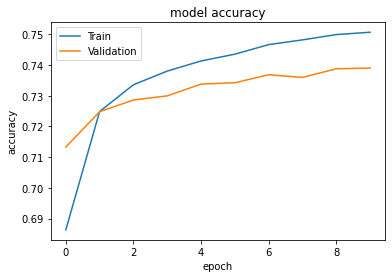

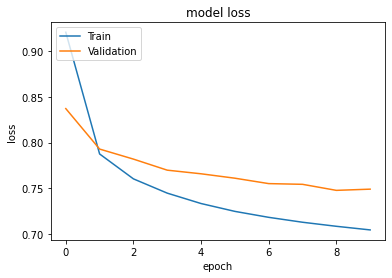

In [43]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [44]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_Nasnet_Sgd"
model.save(export_path)

export_path

'savedModels/cinic_Nasnet_Sgd'

In [45]:
export_path = "savedModels/cinic_Nasnet_Sgd"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

2813/2813 [==============================] - 166s 59ms/step - loss: 0.7335 - acc: 0.7442


[0.7335141525705472, 0.74421114]

# Newton Optimizer (NasNet)

In [30]:
import newton_cg as es

In [31]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1056)              4269716   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10570     
Total params: 4,280,286
Trainable params: 10,570
Non-trainable params: 4,269,716
_________________________________________________________________


In [32]:
newton_opt = es.EHNewtonOptimizer(0.001)

model.compile(
  optimizer=newton_opt,
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
2813/2813 [==============================] - 231s 82ms/step - loss: 1.3989 - acc: 0.5730 - val_loss: 1.0423 - val_acc: 0.6782
Epoch 2/10
2813/2813 [==============================] - 216s 77ms/step - loss: 0.9527 - acc: 0.6872 - val_loss: 0.8893 - val_acc: 0.6998
Epoch 3/10
2813/2813 [==============================] - 214s 76ms/step - loss: 0.8655 - acc: 0.7005 - val_loss: 0.8436 - val_acc: 0.7090
Epoch 4/10
2813/2813 [==============================] - 215s 77ms/step - loss: 0.8333 - acc: 0.7069 - val_loss: 0.8228 - val_acc: 0.7152
Epoch 5/10
2813/2813 [==============================] - 216s 77ms/step - loss: 0.8151 - acc: 0.7115 - val_loss: 0.8104 - val_acc: 0.7181
Epoch 6/10
2813/2813 [==============================] - 216s 77ms/step - loss: 0.8028 - acc: 0.7151 - val_loss: 0.8016 - val_acc: 0.7216
Epoch 7/10
2813/2813 [

In [33]:
model.evaluate(test)

2813/2813 [==============================] - 141s 50ms/step - loss: 0.7904 - acc: 0.7210


[0.7904355333574379, 0.72103333]

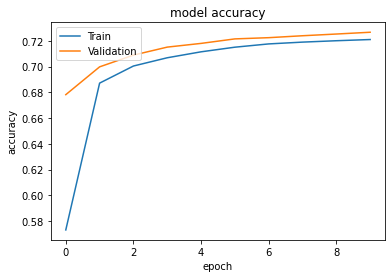

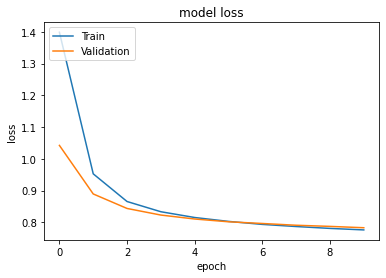

In [34]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_Nasnet_newton"
model.save(export_path)

export_path

'savedModels/cinic_Nasnet_newton'

In [ ]:
export_path = "savedModels/cinic_Nasnet_newton"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

# ----------------------------------------------------------------------------
# Inception_ResNet Model

In [36]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

# Adam Optimizer (Inception_ResNet)

In [47]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1536)              54336736  
_________________________________________________________________
dense_6 (Dense)              (None, 10)                15370     
Total params: 54,352,106
Trainable params: 15,370
Non-trainable params: 54,336,736
_________________________________________________________________


In [48]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
2813/2813 [==============================] - 404s 144ms/step - loss: 0.6528 - acc: 0.7809 - val_loss: 0.6252 - val_acc: 0.7898
Epoch 2/10
2813/2813 [==============================] - 383s 136ms/step - loss: 0.5892 - acc: 0.8000 - val_loss: 0.6676 - val_acc: 0.7777
Epoch 3/10
2813/2813 [==============================] - 385s 137ms/step - loss: 0.5672 - acc: 0.8067 - val_loss: 0.5533 - val_acc: 0.8144
Epoch 4/10
2813/2813 [==============================] - 383s 136ms/step - loss: 0.5570 - acc: 0.8104 - val_loss: 0.5674 - val_acc: 0.8091
Epoch 5/10
2813/2813 [==============================] - 384s 137ms/step - loss: 0.5451 - acc: 0.8132 - val_loss: 0.5600 - val_acc: 0.8128
Epoch 6/10
2813/2813 [==============================] - 385s 137ms/step - loss: 0.5403 - acc: 0.8158 - val_loss: 0.5597 - val_acc: 0.8109
Epoch 7/10
2813/2813 [==============================] - 384s 136ms/step - loss: 0.5335 - acc: 0.8170 - val_loss: 0.5780 - val_acc: 0.8060
Epoch 8/10
2813/2813 [============

In [49]:
model.evaluate(test)

2813/2813 [==============================] - 317s 113ms/step - loss: 0.5903 - acc: 0.8044


[0.5903434711755106, 0.8043778]

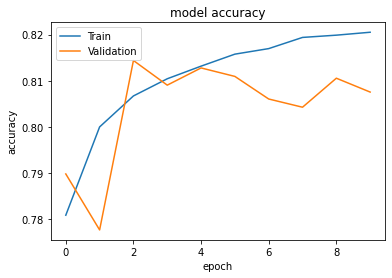

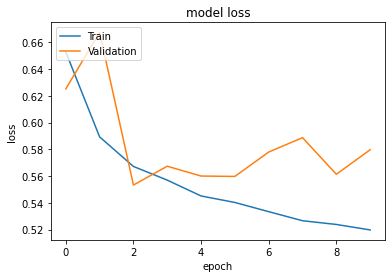

In [50]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [51]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_incResnet_adam"
model.save(export_path)

export_path

'savedModels/cinic_incResnet_adam'

In [52]:
export_path = "savedModels/cinic_incResnet_adam"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

2813/2813 [==============================] - 330s 117ms/step - loss: 0.5903 - acc: 0.8044


[0.5903171909250613, 0.8043778]

# SGD Optimizer (Inception_ResNet)

In [53]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1536)              54336736  
_________________________________________________________________
dense_7 (Dense)              (None, 10)                15370     
Total params: 54,352,106
Trainable params: 15,370
Non-trainable params: 54,336,736
_________________________________________________________________


In [54]:
model.compile(
  optimizer="SGD",
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
2813/2813 [==============================] - 411s 146ms/step - loss: 0.6630 - acc: 0.7768 - val_loss: 0.5972 - val_acc: 0.7957
Epoch 2/10
2813/2813 [==============================] - 388s 138ms/step - loss: 0.5808 - acc: 0.8021 - val_loss: 0.5704 - val_acc: 0.8058
Epoch 3/10
2813/2813 [==============================] - 387s 138ms/step - loss: 0.5593 - acc: 0.8072 - val_loss: 0.5671 - val_acc: 0.8041
Epoch 4/10
2813/2813 [==============================] - 388s 138ms/step - loss: 0.5475 - acc: 0.8111 - val_loss: 0.5446 - val_acc: 0.8133
Epoch 5/10
2813/2813 [==============================] - 386s 137ms/step - loss: 0.5383 - acc: 0.8138 - val_loss: 0.5468 - val_acc: 0.8098
Epoch 6/10
2813/2813 [==============================] - 388s 138ms/step - loss: 0.5306 - acc: 0.8156 - val_loss: 0.5540 - val_acc: 0.8091
Epoch 7/10
2813/2813 [==============================] - 387s 137ms/step - loss: 0.5243 - acc: 0.8172 - val_loss: 0.5669 - val_acc: 0.8044
Epoch 8/10
2813/2813 [============

In [55]:
model.evaluate(test)

2813/2813 [==============================] - 318s 113ms/step - loss: 0.5393 - acc: 0.8138


[0.5393403593147518, 0.8137889]

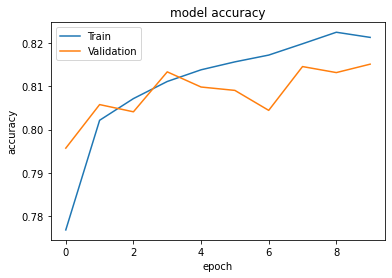

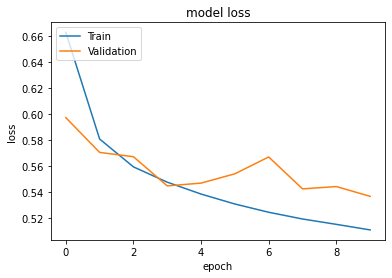

In [56]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [57]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_incResnet_sgd"
model.save(export_path)

export_path

'savedModels/cinic_incResnet_sgd'

In [58]:
export_path = "savedModels/cinic_incResnet_sgd"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)

2813/2813 [==============================] - 335s 119ms/step - loss: 0.5394 - acc: 0.8138


[0.5393654217276758, 0.8137889]

# Newton Optimizer (Inception_ResNet)

In [37]:
import newton_cg as es

In [38]:
num_of_classes = 10

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1536)              54336736  
_________________________________________________________________
dense_4 (Dense)              (None, 10)                15370     
Total params: 54,352,106
Trainable params: 15,370
Non-trainable params: 54,336,736
_________________________________________________________________


In [39]:
newton_opt = es.EHNewtonOptimizer(0.001)

model.compile(
  optimizer=newton_opt,
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train, epochs=10, verbose=1, steps_per_epoch=len(train), 
         validation_data=test, validation_steps= int(0.2*len(test)))

Epoch 1/10
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
eso._resource_compute_dense() called.
eso._resource_compute_dense() FINISHED.
2813/2813 [==============================] - 419s 149ms/step - loss: 1.2174 - acc: 0.6206 - val_loss: 0.8097 - val_acc: 0.7553
Epoch 2/10
2813/2813 [==============================] - 404s 144ms/step - loss: 0.7341 - acc: 0.7623 - val_loss: 0.6730 - val_acc: 0.7760
Epoch 3/10
2813/2813 [==============================] - 402s 143ms/step - loss: 0.6626 - acc: 0.7733 - val_loss: 0.6364 - val_acc: 0.7830
Epoch 4/10
2813/2813 [==============================] - 404s 144ms/step - loss: 0.6365 - acc: 0.7795 - val_loss: 0.6201 - val_acc: 0.7881
Epoch 5/10
2813/2813 [==============================] - 402s 143ms/step - loss: 0.6230 - acc: 0.7828 - val_loss: 0.6103 - val_acc: 0.7910
Epoch 6/10
2813/2813 [==============================] - 404s 144ms/step - loss: 0.6138 - acc: 0.7852 - val_loss: 0.6029 - val_acc: 0.7927
Epoch 7/10
2813/

In [40]:
model.evaluate(test)

2813/2813 [==============================] - 300s 107ms/step - loss: 0.6013 - acc: 0.7918


[0.6012972088161839, 0.7918111]

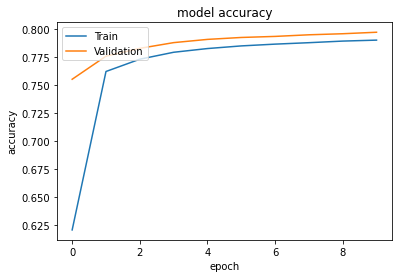

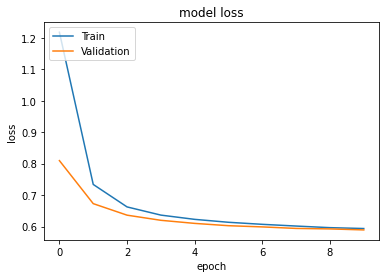

In [41]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [42]:
import time
import datetime

t = time.time()

export_path = "savedModels/cinic_incResnet_newton"
model.save(export_path)

export_path

'savedModels/cinic_incResnet_newton'

In [ ]:
export_path = "savedModels/cinic_incResnet_newton"
reloaded = tf.keras.models.load_model(export_path,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.evaluate(test)